## Problem 1. 
$$
\begin{split}\min \quad &\Vert X\beta-y\Vert_1\\
\text{s.t.} \quad & \beta\in \mathcal{X}
\end{split}$$
(a) Projected Gradient Descent
$$\beta_{t+1}=Proj_{\mathcal{X}} (\beta-\eta g_t),\quad g_t \in \partial (\Vert X\beta-y\Vert_1)$$.

The projection onto the unit simplex $\mathcal{X}=\{\beta:\beta \geq 0,\sum \beta_i =1\}$ was discussed in HW2.

In [103]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
from __future__ import division

X=np.load("X.npy")
y=np.load("y.npy")
y_corr=np.load("y_corr.npy")

In [80]:
def proj_unit_simplex(x):
    mu=1/x.shape[0]
    dmu=float("inf")
    print("x={}".format(x))
    while (abs(dmu)>0):
        h=(np.sum([max(i-0.5*mu,0) for i in x])-1)
        print("h={}".format(h))
        grad = np.sum(-0.5*((x-0.5*mu)>0))
        print("grad={}".format(grad))
        if (grad==0):
            break
        dmu = h/grad
        mu = mu+dmu
        print("mu={}".format(mu))
        proj =[max(i-0.5*mu, 0) for i in x]
        print("proj={}".format(proj))
    return proj

In [84]:
def proj(x):
    n, = x.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if x.sum() == 1 and np.alltrue(x >= 0):
        # best projection: itself!
        return x
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(x)[::-1]
    cssx = np.cumsum(x)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssx - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssx[rho] - 1) / rho
    # compute the projection by thresholding v using theta
    v = (x - theta).clip(min=0)
    return v


In [89]:
def proj_gd(X,y, eta, T=int(1e3)):
    beta = np.zeros(X.shape[1])
    loss = []
    for t in range(T):
        beta=proj(beta-eta*X.T.dot(np.sign(X.dot(beta)-y)))
        loss.append(la.norm(X.dot(beta)-y,1))
    return loss

In [90]:
loss_pdg=proj_gd(X,y, eta=1e-5)

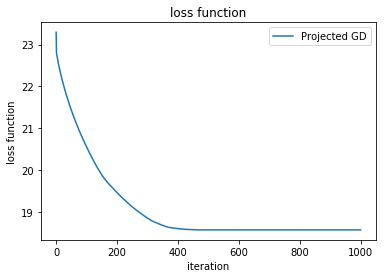

In [91]:
fig=plt.figure()
plt.plot(loss_pdg, label='Projected GD')
plt.title('loss function')
plt.xlabel('iteration')
plt.ylabel('loss function')
plt.legend()

(b) robustness properties

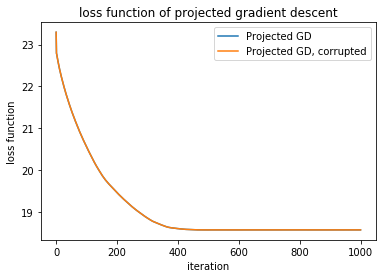

In [95]:
loss_pdg_corr=proj_gd(X,y_corr, eta=1e-5)
fig=plt.figure()
plt.plot(loss_pdg, label='Projected GD')
plt.plot(loss_pdg_corr, label='Projected GD, corrupted')
plt.title('loss function of projected gradient descent')
plt.xlabel('iteration')
plt.ylabel('loss function')
plt.legend()

Compare with the performance of
$$
\begin{split}\min \quad &\frac{1}{2}\Vert X\beta-y\Vert_2\\
\text{s.t.} \quad & \beta\in \mathcal{X}
\end{split}$$
with projected gradient descent 

In [110]:
def proj_gd_l2(X,y, eta, T=int(1e3)):
    beta = np.zeros(X.shape[1])
    loss = []
    for t in range(T):
        beta=proj(beta-eta*X.T.dot(X.dot(beta)-y))
        loss.append(0.5*la.norm(X.dot(beta)-y))
    return loss

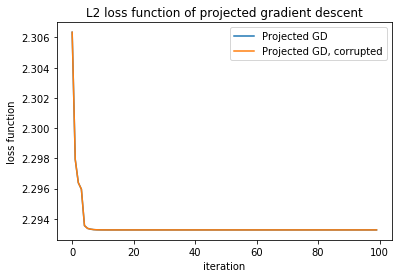

In [111]:
eigen =la.eigvals(X.transpose().dot(X))
loss_l2=proj_gd_l2(X,y, eta=1/max(eigen),T=100)
loss_l2_corr=proj_gd_l2(X,y_corr, eta=1/max(eigen),T=100)

fig=plt.figure()
plt.plot(loss_l2, label='Projected GD')
plt.plot(loss_l2_corr, label='Projected GD, corrupted')
plt.title('L2 loss function of projected gradient descent')
plt.xlabel('iteration')
plt.ylabel('loss function')
plt.legend()

## Problem 2. Mirror Descent

$$\beta_{t+1}=\text{argmin}_{\beta \in \mathcal{X}}\quad \eta g_t^T \beta +D_{\phi}(\beta,\beta_t),\quad g_t \in \partial (\Vert X\beta-y\Vert_1)$$
$$
\mathcal{X}=\{\beta: \beta \geq 0: \sum \beta_i =1\}
$$
$$
\phi(\beta)=\sum \beta_i\log \beta_i
$$
$$
D_\phi(x,y) = \sum x_i\log\frac{x_i}{y_i}
$$

In [120]:
def mirror_descent(X,y, eta, T=int(1e3)):
    beta = np.ones(X.shape[1])/X.shape[1]
    loss = []
    for t in range(T):
        grad =X.T.dot(np.sign(X.dot(beta)-y))
        lam = np.log(1/(np.sum(beta*np.exp(-eta*grad))))-1
        beta =beta*np.exp(-eta*grad+lam+1)
        loss.append(la.norm(X.dot(beta)-y,1))
    return loss,beta

beta=[0.0469175  0.06175398 0.05178969 0.04748475 0.03629062 0.05559994
 0.03746356 0.07687167 0.08256118 0.03287129 0.06817751 0.04503461
 0.04930933 0.07911248 0.00624476 0.00749648 0.00165611 0.07208449
 0.06647181 0.07480825]


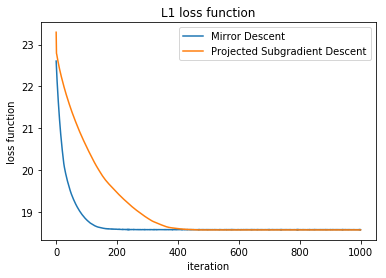

In [122]:
loss_md,beta=mirror_descent(X,y, eta=1e-3,T=1000)

fig=plt.figure()
plt.plot(loss_md, label='Mirror Descent')
plt.plot(loss_pdg, label='Projected Subgradient Descent')
plt.title('L1 loss function')
plt.xlabel('iteration')
plt.ylabel('loss function')
plt.legend()
print("beta={}".format(beta))

## Problem 3. Matrix Completion

### (a) subgradient of nuclear norm

In [144]:
def subgradient_nuclear(X):
    u, s, vh = np.linalg.svd(X, full_matrices=True)
    d = np.sign(s)
    D = np.zeros(X.shape)
    for i in range(len(d)):
        D[i,i] =d[i]
    Z = u.dot(D.dot(vh))
    return Z

### (b) projection

In [135]:
def proj_Omega(X,O, M):
    Ones =np.ones(X.shape)
    return (Ones-O)*X+O*M
    

In [136]:
import pandas as pd
M =pd.read_csv("./MatrixCompletion/M.csv", sep = ",", header =None)
O =pd.read_csv("./MatrixCompletion/O.csv", sep = ",", header =None)

### (c) implementation

In [140]:
def matrix_completion1(O,M, T = int(1e4)):
    X = np.ones(M.shape)
    err = []
    for t in range(T):
        eta =1.0/(t+1)
        X = proj_Omega(X-eta*subgradient_nuclear(X), O,M)
        err.append(la.norm(M-X)/(100**2))
    return err

def matrix_completion2(O,M, T = int(1e4)):
    X = np.ones(M.shape)
    err = []
    for t in range(T):
        eta =1.0/np.sqrt(t+1)
        X = proj_Omega(X-eta*subgradient_nuclear(X), O,M)
        err.append(la.norm(M-X)/(100**2))
    return err

### (d) plots

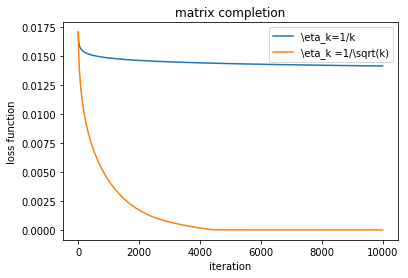

In [145]:
err1= matrix_completion1(O,M)
err2= matrix_completion2(O,M)

fig=plt.figure()
plt.plot(err1, label='\eta_k=1/k')
plt.plot(err2, label='\eta_k =1/\sqrt(k)')
plt.title('matrix completion')
plt.xlabel('iteration')
plt.ylabel('loss function')
plt.legend()

### (e)What is the rank of the intermediate iterates? Why is this the case?

## Problem 4. SVRG

$$\min_\beta \frac{1}{N} \sum_{i=1}^N \beta^T x_i +\log()\Vert$$

In [194]:
X_train = pd.read_csv('digits/X_digits_train.csv',sep=' ', header = None)
X_test = pd.read_csv('digits/X_digits_test.csv',sep=' ', header = None)
y_train = pd.read_csv('digits/y_digits_train.csv',sep=' ', header = None)
y_test = pd.read_csv('digits/y_digits_test.csv',sep=' ', header = None)
X_train = np.array(X_train)
y_train = np.eye(10)[np.array(y_train).astype(int).reshape(-1)] 
X_test = np.array(X_test) 
y_test = np.eye(10)[np.array(y_test).astype(int).reshape(-1)]
beta=np.zeros([64,10])

In [195]:
y_train.shape

(1198, 10)

In [196]:
X_train.shape

(1198, 64)

In [207]:
def grad_logistic( X, y, beta, mu):
    N = X.shape[0]
    grad= np.zeros(beta.shape)
    for i in range(beta.shape[1]):
        grad[:,i]=1.0/N*np.sum(
                    X*y[:,i].reshape([N,1])
                    -X*np.exp(X.dot(beta[:,i].reshape([beta.shape[0],1])))
                    /np.sum(np.exp(-X.dot(beta)), axis =1).reshape([N,1])
                    , axis =0)
        +mu*beta[:,i]
    return grad
   
def loss_function(X,y,beta, mu):
    N=X.shape[0]
    tmp=0
    for i in range(beta.shape[1]):
        tmp+= (X*y[:,i].reshape([N,1])).dot(beta[:,i])
    loss =1.0/N*np.sum(tmp+np.log(np.sum(np.exp(-X.dot(beta)), axis =1)), axis =0)+mu*(la.norm(beta)**2)
    return loss

In [217]:
def gradient_descent_logistic(X, y, mu, c, T):
    beta = np.zeros([64,10])
    f_value = []
    N = X.shape[0]
    for t in range(T):
        grad=grad_logistic(X, y, beta, mu)
        eta = c/(t+1)
        beta = beta- eta*grad
        f_value.append(loss_function(X,y,beta,mu))
    return beta,f_value

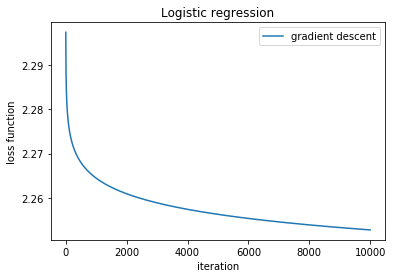

In [219]:
beta, loss_dg = gradient_descent_logistic(X_train, y_train, mu =1, c = 1e-4,  T=int(1e4))
fig=plt.figure()
plt.plot(loss_dg, label='gradient descent')
plt.title('Logistic regression')
plt.xlabel('iteration')
plt.ylabel('loss function')
plt.legend()

In [239]:
def stochastic_grad_logistic(x,k, y, beta, mu):
    grad= np.zeros(beta.shape)
    N=y.shape[0]
    for i in range(beta.shape[1]):
        grad[:,i]=1.0/N*(x*y[k,i]-x*np.exp(x.dot(beta[:,i]))/np.sum(np.exp(-x.dot(beta)))) \
                    +mu*beta[:,i]
    return grad

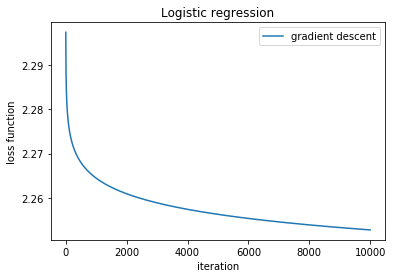

In [240]:
np.random.seed(42)
def stochastic_gradient_descent_logistic(X, y, mu, c, T):
    beta = np.zeros([64,10])
    f_value = []
    N=X.shape[0]
    for t in range(T):
        k=np.random.randint(0, N-1)
        x=X[k,:]
        grad=stochastic_grad_logistic(x, k, y, beta, mu)
        eta = c/(t+1)
        beta = beta- eta*grad
        f_value.append(loss_function(X,y,beta,mu))
    return beta,f_value

beta_sto, loss_sdg = stochastic_gradient_descent_logistic(X_train, y_train, mu =1, c = 1e-4,  T=int(1198e4))
fig=plt.figure()
plt.plot(loss_dg, label='gradient descent')
plt.title('Logistic regression')
plt.xlabel('iterationa')
plt.ylabel('loss function')
plt.legend()

In [ ]:
def SVRG_logistic(X,y, mu, S,T):
    beta = np.zeros([64,10])
    beta_s
    f_value = []
    n_grad_evals =[]
    num_eval=0
    N=X.shape[0]
    for s in range(S):
        beta=beta_s
        grad = grad_logistic(X, y, beta_s, mu)
        num_eval+=N
        k=np.random.randint(0, N-1)
        for t in range(T):
            beta =beta-eta*(stochastic_grad_logistic(x, k, y, beta, mu)-stochastic_grad_logistic(x,k, y, beta_s, mu)+grad)
            beta_s =beta
            num_eval+=2
            f_value.append(loss_function(X,y,beta,mu))
            n_grad_evals.appen(N)
    return beta,f_value, n_grad_evals
        
            

## Problem 5

In [ ]:
X_news_train=scipy.io.mmread("news/X_news_train.mtx")
X_news_test=scipy.io.mmread("news/X_news_test.mtx")
y_news_train = pd.read_csv('news/y_news_train.csv',sep=' ', header = None)
y_news_test = pd.read_csv('news/y_news           _test.csv',sep=' ', header = None)